## Demonstration of Model Selection for Polynomial Regression

This jupyter notebook is part of a [collection of notebooks](../index.ipynb) on various topics of Digital Signal Processing. Please direct questions and suggestions to [Sascha.Spors@uni-rostock.de](mailto:Sascha.Spors@uni-rostock.de).

This notebook illustrates model selection for a polynomial regression model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold, train_test_split
from matplotlib.ticker import MaxNLocator

np.random.seed(42)

### Generate Dataset

In the following, a synthetic dataset with $N$ examples is generated by implementing a polynomial relationship between the dependent $x$ and independent variable $y$, and additive normal distributed noise.

In [2]:
N = 200  # total number of examples
theta = [2, 2e-1, 5e-2, -1e-2, 1e-3]  # coefficients of polynomial data generation model


def generate_data(theta, N):

    X = np.random.uniform(low=-10, high=10, size=N)
    Xv = np.vander(X, len(theta), increasing=True)
    Y = Xv @ theta
    # add normal distributed noise
    Y += 2 * np.random.normal(size=N)

    return X, Y


X, Y = generate_data(theta, N)

The data points are plotted together with the polynomial model used for data generation in order to get an impression on the structure of the dataset.

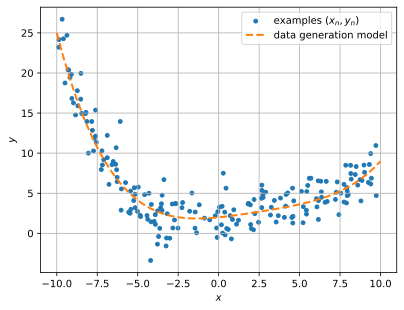

In [3]:
def plot_data(X, Y, ylabel=r'$y$', **kwargs):

    plt.scatter(X, Y, s=15, **kwargs)
    plt.xlabel(r'$x$')
    plt.ylabel(ylabel)
    plt.grid()


def predict(X, theta):

    Xv = np.vander(X, len(theta), increasing=True)
    Y = np.dot(Xv, theta)

    return Y


plot_data(X, Y, label=r'examples $(x_n, y_n)$')
xl = np.linspace(-10, 10)
plt.plot(xl, predict(xl, theta), color='C1', linestyle='--',
         linewidth=2, label='data generation model')
plt.legend()

### Model Selection

The aim is to determine the optimal order $\hat{P}$ of the polynomial regression model for the given dataset. For this purpose, candidate models are trained and evaluated on a training and validation subset of the data for $\hat{P}=1, 2, \dots, 20$. The data subsets are derived by repeated $K$-fold cross validation with $K=2$ and 10 repetitions. The mean-squared error (MSE) between the true $y_n$ and estimated output $\hat{y}_n$ for a given $x_n$ is used as evaluation metric.

First some helper functions are defined

In [4]:
def polynomial_regression(x, Y, N, mu=0):

    X = np.vander(x, N, increasing=True)
    theta = np.linalg.inv((X.T @ X) + mu * np.eye(X.shape[1])) @ X.T @ Y

    return theta


def compute_MSE(Y, Y_hat):

    return 1/len(Y) * np.linalg.norm(Y - Y_hat)

Now the cross validation of the candidate models is performed

In [5]:
kf = RepeatedKFold(n_splits=2, n_repeats=10)
MSE = list()

for P in range(1, 20):

    MSE_train = 0
    MSE_eval = 0

    for train_index, eval_index in kf.split(X):

        # select the training/evalualtion subsets
        X_train, X_eval = X[train_index], X[eval_index]
        Y_train, Y_eval = Y[train_index], Y[eval_index]
        # train candidate model
        theta_hat = polynomial_regression(X_train, Y_train, P, mu=0)
        # compute MSE on training subset
        Y_hat = predict(X_train, theta_hat)
        MSE_train += compute_MSE(Y_train, Y_hat)
        # compute MSE on evaluation subset
        Y_hat = predict(X_eval, theta_hat)
        MSE_eval += compute_MSE(Y_eval, Y_hat)

    MSE.append((P, MSE_train/kf.get_n_splits(), MSE_eval/kf.get_n_splits()))

MSE = np.array(MSE)

The MSE is plotted against the regression model order $\hat{P}$. From the results it can be concluded that the model has a low MSE and generalizes well for $\hat{P}=5$.

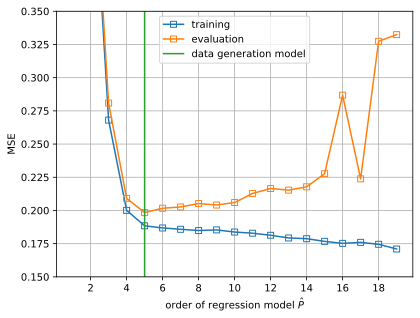

In [6]:
plt.plot(MSE[:, 0], MSE[:, 1], marker='s',
         markerfacecolor='none', label=r'training')
plt.plot(MSE[:, 0], MSE[:, 2], marker='s',
         markerfacecolor='none', label=r'evaluation')
plt.axvline(len(theta), color='C2', label=r'data generation model')

plt.xlabel(r'order of regression model $\hat{P}$')
plt.ylabel(r'MSE')

plt.ylim([0.15, 0.35])
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.grid(True)

### Training and Evaluation of Final Model

The model is retrained with the resulting hyperparameters from the model selection. The dataset is split into a training and testing subset in order to evaluate the generalization of the model.

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

theta_hat = polynomial_regression(X_train, Y_train, 5, mu=0)

The trained polynomial regression is plotted together with the training and testing examples. The trained model fits the data generation model quite well.

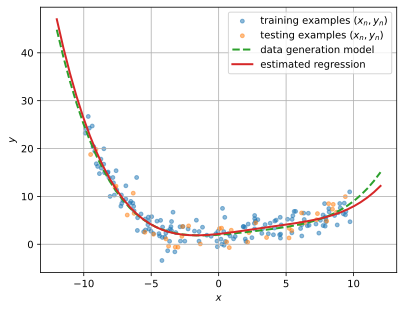

In [8]:
# plot data points
plot_data(X_train, Y_train, alpha=.5, label=r'training examples $(x_n, y_n)$')
plot_data(X_test, Y_test, alpha=.5, label=r'testing examples $(x_n, y_n)$')

# plot regression lines
xl = np.linspace(-12, 12)
plt.plot(xl, predict(xl, theta), color='C2', linestyle='--',
         linewidth=2, label='data generation model')
plt.plot(xl, predict(xl, theta_hat), color='C3', linestyle='-',
         linewidth=2, label='estimated regression')
plt.legend()
plt.grid()

The performance metrics of the model are computed on the training dataset in order to evaluated the performance for unseen examples.

In [9]:
Y_hat = predict(X_test, theta_hat)

TSS = np.sum((Y_test - np.mean(Y_test))**2)
RSS = np.sum((Y_test-Y_hat)**2)
Rs = 1 - RSS/TSS

print('Total sum-of-squares (TSS): \t {0:.5f}'.format(TSS))
print('Residual sum-of-squares (RSS): \t {0:.5f}'.format(RSS))
print('Coefficient of determination: \t {0:.5f}'.format(Rs))

Total sum-of-squares (TSS): 	 887.23901
Residual sum-of-squares (RSS): 	 145.41152
Coefficient of determination: 	 0.83611


**Copyright**

This notebook is provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources).
The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/)
, the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: Sascha Spors, Data driven audio signal processing - Lecture supplementals.